In [27]:
import numpy as np
import nibabel as nib
from dipy.segment.mask import median_otsu
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle

# nii_data

In [2]:
nii_gz_path = 'C:/Users/panag/Desktop/Test/mgh_1001/diff/preproc/mri/diff_preproc.nii.gz'
nii_data  = nib.load(nii_gz_path).get_fdata()

In [3]:
nii_data.shape

(140, 140, 96, 552)

# direction_vectors

In [4]:
direction_vectors_path = 'C:/Users/panag/Desktop/Test/mgh_1001/diff/preproc/bvecs_moco_norm.txt'
direction_vectors = np.genfromtxt(direction_vectors_path)

In [5]:
direction_vectors.shape

(552, 3)

# b_values

In [6]:
b_values_path = 'C:/Users/panag/Desktop/Test/mgh_1001/diff/preproc/bvals.txt'
b_values = np.genfromtxt(b_values_path)
b_values[(b_values > 9_900) & (b_values < 10_100)] = 10_000

In [7]:
unique_b_values, unique_b_values_counts = np.unique(b_values, return_counts=True)

In [8]:
unique_b_values, unique_b_values_counts

(array([    0.,  1000.,  3000.,  5000., 10000.]),
 array([ 40,  64,  64, 128, 256], dtype=int64))

In [9]:
b_value_to_indices = {b_value: np.where(b_values == b_value)[0] for b_value in unique_b_values}

# nii_masked_data

In [10]:
nii_data_masked, mask = median_otsu(nii_data, vol_idx=b_value_to_indices[1_000])

In [11]:
nii_data_masked.shape, mask.shape

((140, 140, 96, 552), (140, 140, 96))

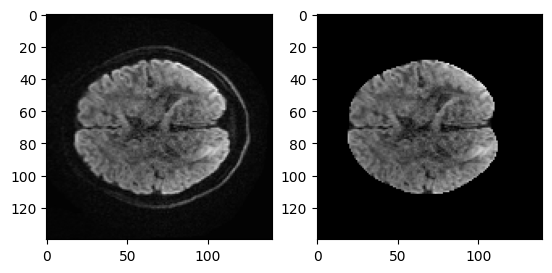

In [24]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(nii_data[:,:,50,b_value_to_indices[1_000][0]], cmap='gray')
ax[1].imshow(nii_data_masked[:,:,50,b_value_to_indices[1_000][0]], cmap='gray')
plt.show()

# least squares

$$
\begin{align*}
& S = S_0 \exp(- \ b \ g \ D \ g^T) \\
& \ln ( S / S_0 ) = - \ b \ g \ D \ g^T \\
& \ln ( S / S_0 ) = - \ b \ 
\begin{bmatrix}
g_0 & g_1 & g_2
\end{bmatrix} \ 
\begin{bmatrix}
D_{0,0} & D_{0,1} & D_{0,2} \\
D_{0,1} & D_{1,1} & D_{1,2} \\
D_{0,2} & D_{1,2} & D_{2,2} \\
\end{bmatrix} \ 
\begin{bmatrix}
g_0 \\ g_1 \\ g_2
\end{bmatrix} \\
& \ln ( S / S_0 ) = - \ b \ 
\begin{bmatrix}
g_0 & g_1 & g_2
\end{bmatrix} \
\begin{bmatrix}
g_0 D_{0,0} + g_1 D_{0,1} + g_2 D_{0,2} \\
g_0 D_{0,1} + g_1 D_{1,1} + g_2 D_{1,2} \\
g_0 D_{0,2} + g_1 D_{1,2} + g_2 D_{2,2} \\
\end{bmatrix} \\
& \ln ( S / S_0 ) = - \ b \ ( \ 
g_0 ( g_0 D_{0,0} + g_1 D_{0,1} + g_2 D_{0,2} ) +
g_1 ( g_0 D_{0,1} + g_1 D_{1,1} + g_2 D_{1,2} ) +
g_2 ( g_0 D_{0,2} + g_1 D_{1,2} + g_2 D_{2,2} )
\ ) \\
& \ln ( S / S_0 ) = - \ b \ ( \ 
g_0 g_0 D_{0,0} + g_0 g_1 D_{0,1} + g_0 g_2 D_{0,2} +
g_1 g_0 D_{0,1} + g_1 g_1 D_{1,1} + g_1 g_2 D_{1,2} +
g_2 g_0 D_{0,2} + g_2 g_1 D_{1,2} + g_2 g_2 D_{2,2}
\ ) \\
& \ln ( S / S_0 ) = - \ b \ ( \ 
g_0 g_0 D_{0,0} + 2 g_0 g_1 D_{0,1} + 2 g_0 g_2 D_{0,2} +
g_1 g_1 D_{1,1} + 2 g_1 g_2 D_{1,2} + g_2 g_2 D_{2,2}
\ ) \\
& \ln ( S / S_0 ) = 
\begin{bmatrix}
D_{0,0} & D_{0,1} & D_{0,2} & D_{1,1} & D_{1,2} & D_{2,2} \\
\end{bmatrix} \
(-b) \
\begin{bmatrix}
g_0 g_0 \\ 2 g_0 g_1 \\ 2 b g_0 g_2 \\
g_1 g_1 \\ 2 g_1 g_2 \\ g_2 g_2 \\
\end{bmatrix}
\\
\end{align*}
$$

In [22]:
b_value = 1_000
epsilon = 1e-9

lstsq_results = {}

# create a progress bar
pbar = tqdm(total=np.sum(mask))

# loop over unmasked voxels
for i in range(nii_data.shape[0]):
    for j in range(nii_data.shape[1]):
        for k in range(nii_data.shape[2]):
            if mask[i,j,k]:
                
                # calculate y
                S = nii_data[i, j, k, b_value_to_indices[b_value]]
                S = np.where(S > 0.0, S, epsilon)
                S0 = max(nii_data[i, j, k, b_value_to_indices[0]].mean(), epsilon)
                y = np.log(S / S0)
                
                # calculate X
                g = direction_vectors[b_value_to_indices[b_value], :]
                X = - b_value * np.array([g[:,0]**2, 2*g[:,0]*g[:,1], 2*g[:,0]*g[:,2], 
                                          g[:,1]**2, 2*g[:,1]*g[:,2], g[:,2]**2]).T
                
                # calculate lstsq
                params = np.linalg.lstsq(X, y, rcond=None)[0]
                
                # reconstruct tensor
                D = np.array([[params[0], params[1], params[2]],
                              [params[1], params[3], params[4]],
                              [params[2], params[4], params[5]]])
                
                # try Cholesky decomposition
                try:
                    L = np.linalg.cholesky(D)
                except:
                    pass # invalid diffusion tensor
                else:
                    lstsq_results[(i,j,k)] = D
                
                # update progress bar
                pbar.update()

pbar.close()

100%|██████████| 307317/307317 [00:26<00:00, 11699.72it/s]


In [25]:
np.sum(mask), len(lstsq_results), np.sum(mask) - len(lstsq_results)

(307317, 300446, 6871)

# save results

In [28]:
with open('lstsq_results.pkl', 'wb') as f:
    pickle.dump(lstsq_results, f)

# load results

In [ ]:
with open('lstsq_results.pkl', 'rb') as f:
    lstsq_results = pickle.load(f)